<h1>Путешествие в Спрингфилд</h1>

Домашнее задания для курса от [Deep Learning School](https://www.dlschool.org/)

Домашнее задание представляет из себя [конкурс](https://www.kaggle.com/c/journey-springfield/overview) на платформе kaggle.com

# Загрузка данных

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
!unzip /content/gdrive/MyDrive/dataset/journey-springfield.zip -d /content/data

In [ ]:
!nvidia-smi

Mon Nov 15 11:40:59 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Импорт библиотек

In [ ]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
import torchvision.models as models
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

# воспроизводимость результатов
torch.manual_seed(1000-7);

In [ ]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']

# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224

MEAN_ImgNet, STD_ImgNet = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Подготовка данных


In [ ]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return len(self.files)
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа

        transform = {
            'test': transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(MEAN_ImgNet, STD_ImgNet)                         
            ]),

            'train': transforms.Compose([
                transforms.RandomHorizontalFlip(p=0.2),
                transforms.RandomGrayscale(p=0.05),                         
                transforms.ToTensor(),
                transforms.Normalize(MEAN_ImgNet, STD_ImgNet)                         
            ]),

            'val': transforms.Compose([
                transforms.RandomRotation((-5, 5)),
                transforms.ToTensor(),
                transforms.Normalize(MEAN_ImgNet, STD_ImgNet)                         
            ]),
        }

        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = transform[self.mode](x)

        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return image 


def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [ ]:
TRAIN_DIR = Path('/content/data/train/simpsons_dataset')
TEST_DIR = Path('/content/data/testset/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [ ]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]

train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [ ]:
len(train_files), len(val_files)

(15699, 5234)

# Нейросеть

In [ ]:
def fit_epoch(model, train_loader, criterion, optimizer):
    """
    Обучает одну эпоху и возвращает loss, acuracy
    """

    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc


def eval_epoch(model, val_loader, criterion):
    """
    Валидирует одну эпоху и возвращает loss, acuracy
    """
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc


def train(train_files, val_files, model, epochs, batch_size, criterion, opt):
    """
    Обучение модели
    """

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

### Резнет

In [ ]:
def model_create_or_load(NN, train_val_labels, PATH=None):
    """
    Загрузка модели, если передан параметр PATH, 
    иначе создание модели для transfer learning
    """

    if PATH is None:
        n_classes = len(np.unique(train_val_labels))
        model = NN(pretrained=True)
        
        for param in simple_cnn.parameters():
            param.requires_grad = False

        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, n_classes)
    else:
        model = torch.load(PATH, map_location=DEVICE)
   
    return model.to(DEVICE)

In [ ]:
import copy

PATH_model = '/content/gdrive/MyDrive/dataset/'
FNAME_model = 'resnet50_with_aug.pth'
PATH = PATH_model+FNAME_model

nn_resnet = model_create_or_load(NN=models.resnet50, 
                                  train_val_labels=train_val_labels,
                                  PATH=PATH_model+FNAME_model)

### Симпл

In [ ]:
class SimpleCnn(nn.Module):
  
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.out = nn.Sequential(
            nn.Linear(96 * 5 * 5, 128), 
            nn.Linear(128, 128), 
            nn.Linear(128, n_classes), 
        ) 
  
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

In [ ]:
n_classes = len(np.unique(train_val_labels))
simple_cnn = SimpleCnn(n_classes).to(DEVICE)

### Обучение

In [ ]:
val_dataset = SimpsonsDataset(val_files, mode='val')
    
train_dataset = SimpsonsDataset(train_files, mode='train')

In [ ]:
len(train_dataset), len(val_dataset)

(15699, 5234)

In [ ]:
opt = torch.optim.AdamW(simple_cnn.parameters())
criterion = nn.CrossEntropyLoss()

history = train(train_dataset, val_dataset, model=simple_cnn, 
                epochs=11, batch_size=128, criterion=criterion, opt=opt)

epoch:   0%|          | 0/11 [00:00<?, ?it/s]

loss 2.9179946267762014


epoch:   9%|▉         | 1/11 [02:49<28:10, 169.02s/it]


Epoch 001 train_loss: 2.9180     val_loss 2.5677 train_acc 0.1668 val_acc 0.2812
loss 2.2240254110846216


epoch:  18%|█▊        | 2/11 [05:32<24:52, 165.87s/it]


Epoch 002 train_loss: 2.2240     val_loss 1.8031 train_acc 0.3870 val_acc 0.4941
loss 1.5999826333030591


epoch:  27%|██▋       | 3/11 [08:13<21:49, 163.67s/it]


Epoch 003 train_loss: 1.6000     val_loss 1.3850 train_acc 0.5587 val_acc 0.6242
loss 1.2626272951450248


epoch:  36%|███▋      | 4/11 [10:56<19:01, 163.14s/it]


Epoch 004 train_loss: 1.2626     val_loss 1.1728 train_acc 0.6479 val_acc 0.6859
loss 1.0224186793824914


epoch:  45%|████▌     | 5/11 [13:36<16:13, 162.31s/it]


Epoch 005 train_loss: 1.0224     val_loss 1.0798 train_acc 0.7157 val_acc 0.7073
loss 0.850970511812641


epoch:  55%|█████▍    | 6/11 [16:18<13:29, 161.91s/it]


Epoch 006 train_loss: 0.8510     val_loss 1.0162 train_acc 0.7651 val_acc 0.7360
loss 0.7161966293805329


epoch:  64%|██████▎   | 7/11 [18:57<10:44, 161.15s/it]


Epoch 007 train_loss: 0.7162     val_loss 0.9174 train_acc 0.7961 val_acc 0.7654
loss 0.6243673991652778


epoch:  73%|███████▎  | 8/11 [21:36<08:01, 160.52s/it]


Epoch 008 train_loss: 0.6244     val_loss 0.8792 train_acc 0.8218 val_acc 0.7810
loss 0.5505052721495082


epoch:  82%|████████▏ | 9/11 [24:18<05:21, 160.88s/it]


Epoch 009 train_loss: 0.5505     val_loss 0.9483 train_acc 0.8418 val_acc 0.7759
loss 0.48645219394557604


epoch:  91%|█████████ | 10/11 [27:00<02:41, 161.13s/it]


Epoch 010 train_loss: 0.4865     val_loss 0.8829 train_acc 0.8584 val_acc 0.7921
loss 0.4363120231964655


epoch: 100%|██████████| 11/11 [29:42<00:00, 162.05s/it]


Epoch 011 train_loss: 0.4363     val_loss 0.9004 train_acc 0.8748 val_acc 0.7895


In [ ]:
PATH_model = '/content/gdrive/MyDrive/dataset/'
FNAME_model = 'simple_aug.pth'

torch.save(simple_cnn,
           PATH_model+FNAME_model)

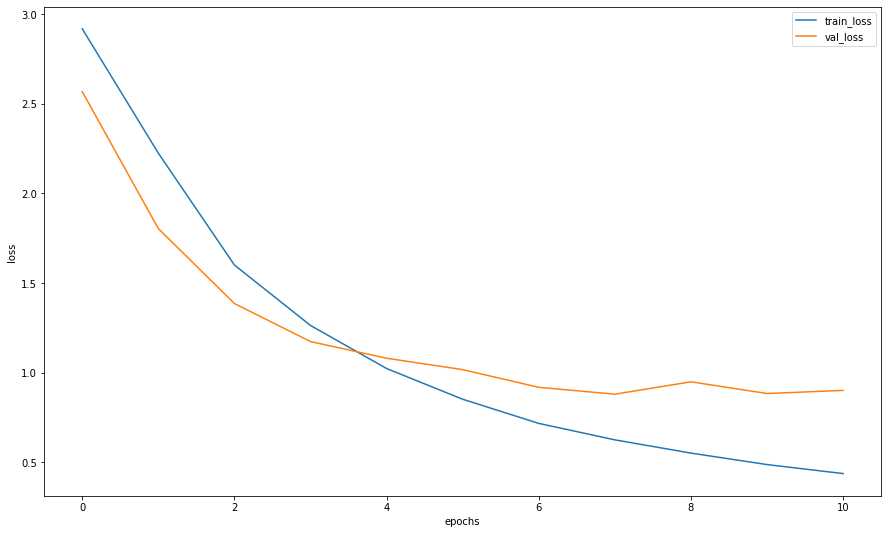

In [ ]:
loss, acc, val_loss, val_acc = zip(*history)

plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [ ]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs


random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(simple_cnn, ex_img.unsqueeze(0))
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(simple_cnn, imgs)
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

from sklearn.metrics import f1_score

f1_score(actual_labels, y_pred, average='micro')

0.85

# Submit

In [ ]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(simple_cnn, test_loader)

In [ ]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))
preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [ ]:
import pandas as pd
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [ ]:
my_submit.to_csv('simple_.csv', index=False)

# Вывод

Лучший скор 0.94580* был достигнут на простой нейронной сети с количеством эпох = 20.

*По результатам сабмита на каггле 